In [7]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import botorch
from tqdm import tqdm

In [29]:
#objective function
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)


bound = 5 #domain of our search space is [-5,5]

#observed quanitities from objective function
torch.manual_seed(1)
train_x = torch.rand(size=(1,1)) * 6 - 3
train_y = forrester_1d(train_x)

xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
ys = forrester_1d(xs)

In [9]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
def fit_gp_model(train_x, train_y, num_train_iters=500):

    """Creates Gaussian Process using train_x and train_y using Gradient Descent

    Returns:
        model: GPModel
    """
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) #objective function for GP to optimizze

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters)):
        optimizer.zero_grad()

        #determine loss
        output = model(train_x)
        loss = -mll(output, train_y)

        #perform gradient descent
        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [25]:
def visualize_gp_belief_and_policy(model, likelihood, policy=None, next_x=None):
    """
    xs: search space to obtain acquisition score
    next_x: location of data point that maximizes acqusition score
    policy: BayesOpt Policy Object
    """
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs)) 
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

        if policy is not None:
            acquisition_score = policy(xs.unsqueeze(1))

        if policy is None:
            plt.figure(figsize=(8, 3))

            #plot objective function and observed values
            plt.plot(xs, ys, label="objective", c="r")
            plt.scatter(train_x, train_y, marker="x", c="k",
                label="observations")

            #plot GP predictions
            plt.plot(xs, predictive_mean, label="mean")
            plt.fill_between(
                xs.flatten(),
                predictive_upper,
                predictive_lower,
                alpha=0.3,
                label="95% CI",
            )

            plt.legend()
            plt.show()

        else:
            fig, ax = plt.subplots(
            2,
            1,
            figsize=(8, 6),
            sharex=True,
            gridspec_kw={"height_ratios": [2, 1]}
        )

            # GP predictions
            ax[0].plot(xs, predictive_mean, label="mean")
            ax[0].scatter(train_x, train_y, marker="x", c='k', label='observations')
            ax[0].fill_between(
                xs.flatten(),
                predictive_upper,
                predictive_lower,
                alpha=0.3,
                label="95% CI",
            )
            

            #plot location of highest acuqisition score in GP viz
            if next_x is not None:
                ax[0].axvline(next_x, linestyle="dotted", c="k")

            #plot distribution of acqusition scores across search space
            ax[1].plot(xs, acquisition_score, c="g")
            ax[1].fill_between(
            xs.flatten(),
            acquisition_score,
            0,
            color="g",
            alpha=0.5
            )

            #plot location of highest acqqisition score in acqusition score viz
            if next_x is not None:
                ax[1].axvline(next_x, linestyle="dotted", c="k")

            ax[1].set_ylabel("acquisition score")

            plt.show()

### Training Loop

iteration 0
incumbent tensor([1.5458]) tensor(2.2041)


100%|██████████| 500/500 [00:01<00:00, 389.14it/s]
/Users/vishesh.javangula@ibm.com/anaconda3/envs/gp_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


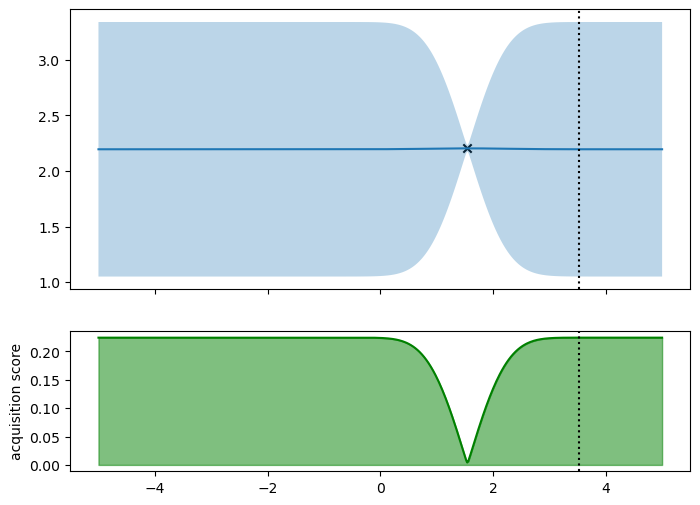

iteration 1
incumbent tensor([1.5458]) tensor(2.2041)


100%|██████████| 500/500 [00:01<00:00, 418.48it/s]
/Users/vishesh.javangula@ibm.com/anaconda3/envs/gp_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


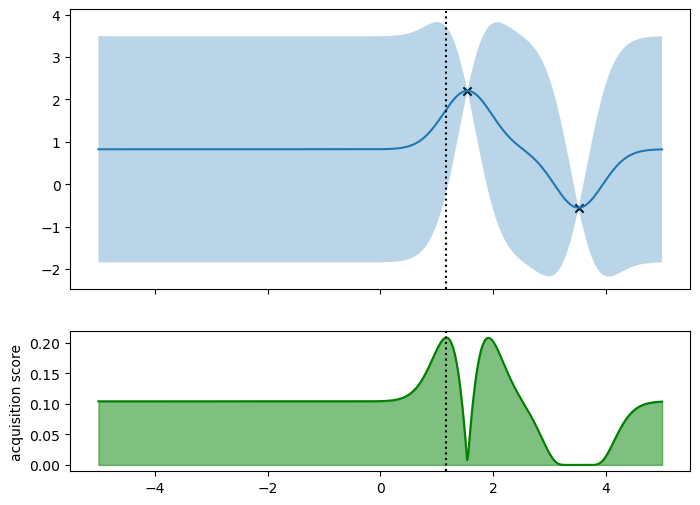

iteration 2
incumbent tensor([1.5458]) tensor(2.2041)


100%|██████████| 500/500 [00:01<00:00, 359.63it/s]
/Users/vishesh.javangula@ibm.com/anaconda3/envs/gp_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


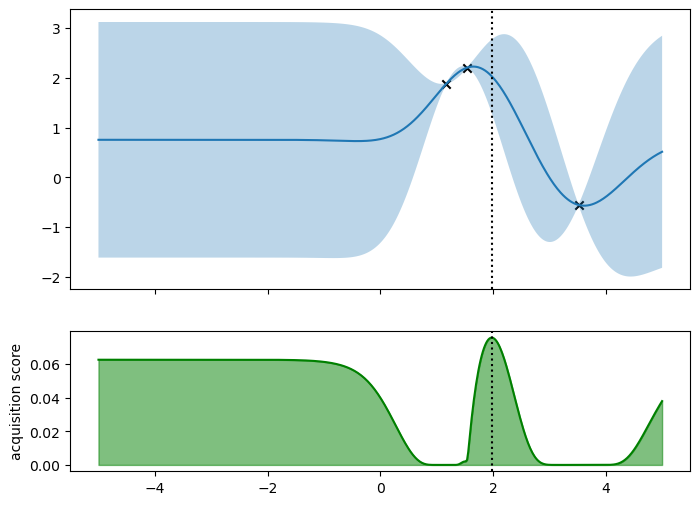

iteration 3
incumbent tensor([1.5458]) tensor(2.2041)


100%|██████████| 500/500 [00:01<00:00, 467.99it/s]
/Users/vishesh.javangula@ibm.com/anaconda3/envs/gp_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


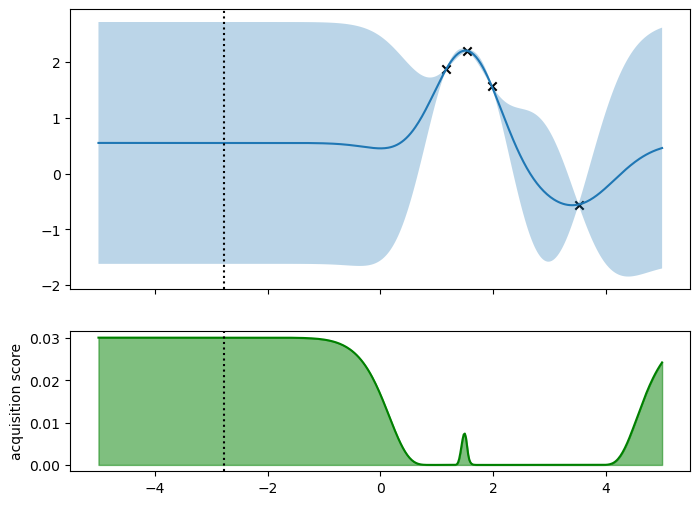

iteration 4
incumbent tensor([1.5458]) tensor(2.2041)


100%|██████████| 500/500 [00:01<00:00, 470.18it/s]
/Users/vishesh.javangula@ibm.com/anaconda3/envs/gp_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


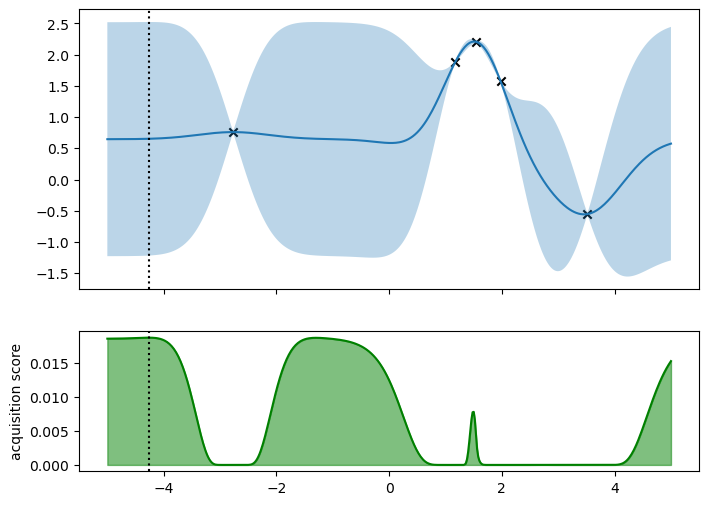

iteration 5
incumbent tensor([1.5458]) tensor(2.2041)


100%|██████████| 500/500 [00:01<00:00, 444.35it/s]
/Users/vishesh.javangula@ibm.com/anaconda3/envs/gp_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


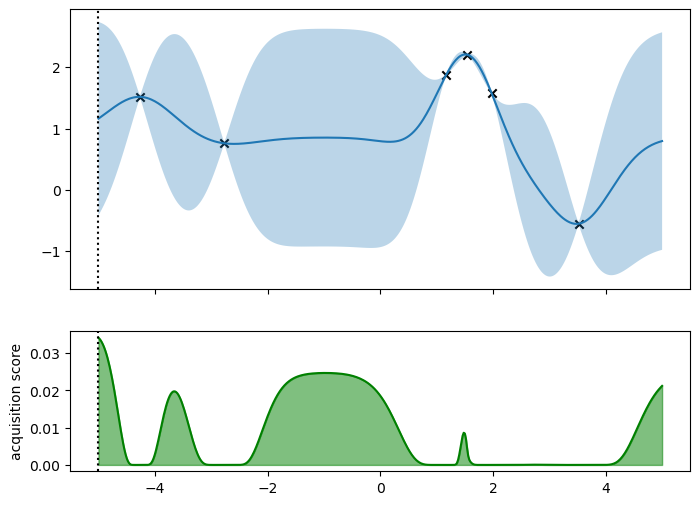

iteration 6
incumbent tensor([-5.]) tensor(4.1659)


100%|██████████| 500/500 [00:01<00:00, 478.28it/s]
/Users/vishesh.javangula@ibm.com/anaconda3/envs/gp_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


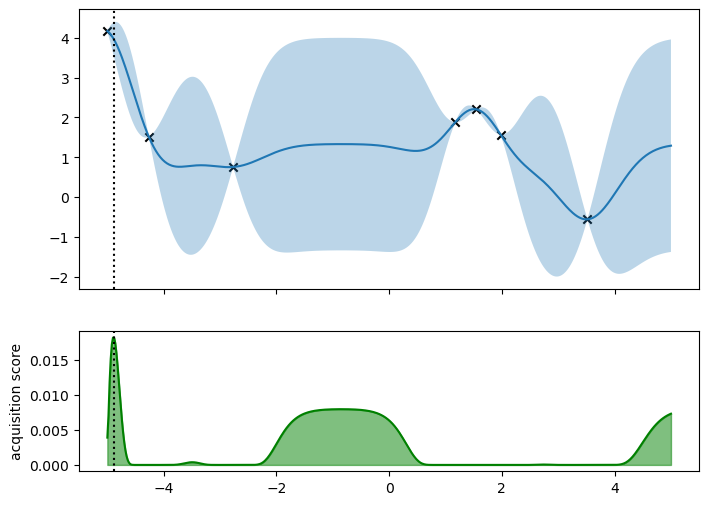

iteration 7
incumbent tensor([-5.]) tensor(4.1659)


100%|██████████| 500/500 [00:01<00:00, 474.39it/s]
/Users/vishesh.javangula@ibm.com/anaconda3/envs/gp_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


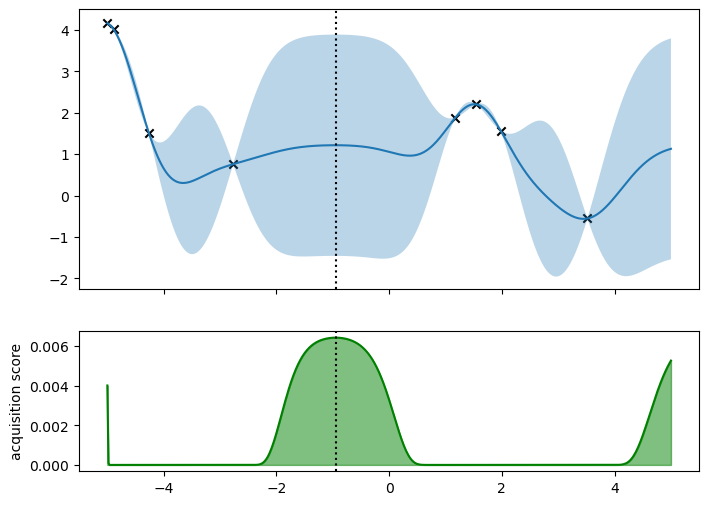

iteration 8
incumbent tensor([-5.]) tensor(4.1659)


100%|██████████| 500/500 [00:01<00:00, 484.08it/s]
/Users/vishesh.javangula@ibm.com/anaconda3/envs/gp_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


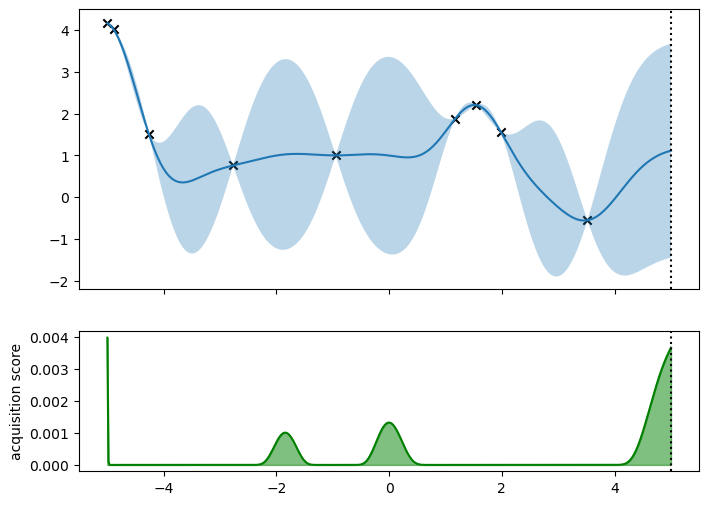

iteration 9
incumbent tensor([5.]) tensor(4.8633)


100%|██████████| 500/500 [00:01<00:00, 479.35it/s]
/Users/vishesh.javangula@ibm.com/anaconda3/envs/gp_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


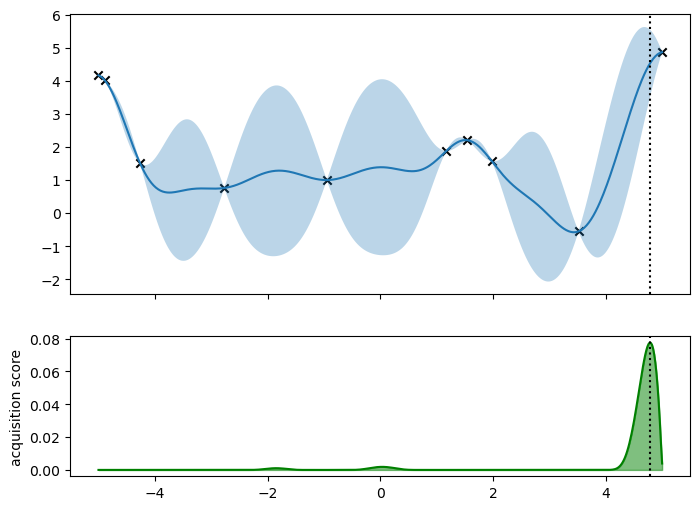

In [30]:

num_queries = 10

for i in range(num_queries):

    #print the best observation thus far, this is our baseline
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    #train GP on observed values
    model, likelihood = fit_gp_model(train_x, train_y)

    #PoI Policy 
    #try setting it to empty tensor? 
    policy = botorch.acquisition.analytic.ExpectedImprovement(model, best_f=train_y.max())
    # with torch.no_grad():
    #     scores = policy(xs.unsqueeze(1))

   #determine next point using policy and optimization algorithm
    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]), #boundary of our search space
        q=1, #number of points we'd like returned
        num_restarts=20, #number of trails to go thorugh to find optimal point
        raw_samples=50, #number of initial points to use for finding optimal point
    )


    visualize_gp_belief_and_policy(model, likelihood, policy,
        next_x=next_x)

    #obtain observation from our black box function
    next_y = forrester_1d(next_x)

    #append to observtions
    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])